In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randn
from numpy.random import choice


n = 3
p = 1
D = 50000

true_beta = np.array([1, 3, 5])

eta = 0.01
datanoise_cov = 30

xdata = np.random.randn(n, D) * 5

ydata = np.dot(true_beta, xdata) + np.random.randn(p, D) * datanoise_cov

# Central data
CentD = D
xcovcent = 2
centnoise = 3

CentAgentX = np.random.randn(n, CentD) * xcovcent
CentAgentY = np.dot(true_beta, CentAgentX) + np.random.randn(p, CentD) * centnoise

In [2]:
def generate_stochastic_matrix(n):
    c = np.abs(np.random.randn(n))
    csum = np.sum(c)
    c = c / csum

    M2 = np.eye(n)

    for k in range(n):
        idx = np.random.permutation(n)
        idx = idx + np.arange(n) * n
        M2.flat[idx] = M2.flat[idx] + c[k]

    return M2

def gradient_linear(ydata, xdata, beta0, n, p, D):
    dbeta = np.zeros((p, n))

    for j in range(D):
        dbeta += np.outer(ydata[:, j] - np.dot(beta0, xdata[:, j]), xdata[:, j])

    dbeta = -dbeta / D
    return dbeta



In [3]:
# Parameters
T = 3000
N = 5  
eta = 0.01  

datadist = T
DataAgentsX = np.zeros((n, datadist, N))
DataAgentsY = np.zeros((p, datadist, N))

dataser = np.arange(1, T + 1)
for i in range(N):
    samples = np.random.choice(dataser, datadist)
    DataAgentsX[:, :, i] = xdata[:, samples - 1] 
    DataAgentsY[:, :, i] = ydata[:, samples - 1] 

W = generate_stochastic_matrix(N)-np.eye(N)

# Initialize variables
beta = randn(p, n)
beta_naive = beta.copy()

switchS1 = 10
switchS2 = 10
count = 0
state = 1

# S1 initializations
Ws1 = np.eye(p)
ts1 = np.trace(Ws1)
betaS1 = beta.copy()
betaS1_n = beta.copy()
s1count = 0

# S2 initializations
Ws2 = np.eye(p)
ts2 = np.trace(Ws2)
betaS2 = beta.copy()
betaS2_n = beta.copy()
betaS2_dist = np.tile(beta, (N, 1, 1))
betaS2_dist_n = np.tile(beta, (N, 1, 1))
s2count = 1

# Keep track of betas for plots
beta_traj = np.zeros((p, n, T))
beta_traj[:, :, 0] = beta.copy()

beta_n_traj = np.zeros((p, n, T))
beta_n_traj[:, :, 0] = beta_naive.copy()

betaNorm = np.zeros(T)
betaNorm_naive = np.zeros(T)



In [4]:
for i in range(T):
    count += 1
    if count == switchS1:
        state = 2
        count = 0
    elif count == switchS2:
        state = 1
        count = 0

    if state == 2:
        s2count += 1

    # Decentralized learning
    DataS2X = DataAgentsX[:, :s2count, :]
    DataS2Y = DataAgentsY[:, :s2count, :]

    betaS2_temp = betaS2_dist.copy()
    for j in range(N):
        gradN = gradient_linear(DataS2Y[:, :, j], DataS2X[:, :, j], beta, n, p, s2count)
        betaS2_temp[j] = betaS2 - eta * gradN

    betaS2_dist = np.zeros((N, p, n))
    for j in range(N):
        for k in range(N):
            betaS2_dist[j] += W[j, k] * betaS2_temp[k]

    betaS2 = np.mean(betaS2_dist, axis=0)

    errS2 = np.zeros(DataS2Y[:, :, 0].shape)
    for j in range(N):
        errS2 += DataS2Y[:, :, j] - np.dot(betaS2, DataS2X[:, :, j])

    beta = betaS2

    betaNorm[i] = np.linalg.norm(beta - true_beta)

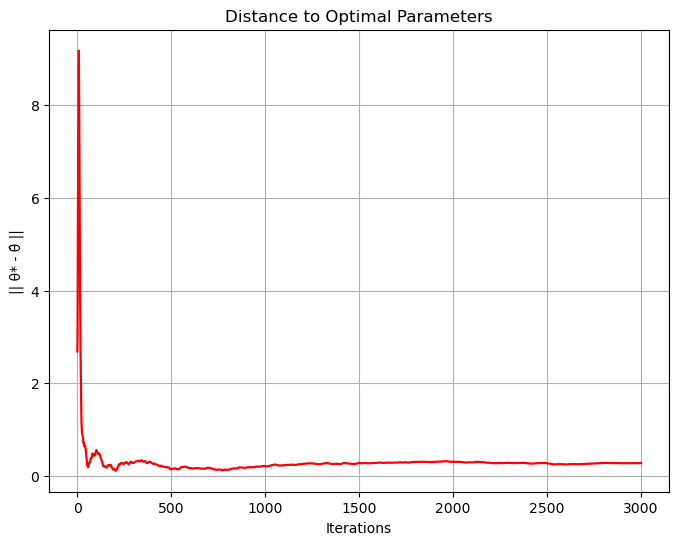

In [5]:
betaNorm.shape
import matplotlib.pyplot as plt

# Assuming betaNorm is already computed and available
# Plotting code
plt.figure(figsize=(8, 6))
plt.plot(range(len(betaNorm)), betaNorm, 'r-', linewidth=1.6)
plt.xlabel('Iterations')
plt.ylabel('|| θ* - θ̂ ||')
plt.title('Distance to Optimal Parameters')
plt.grid(True)
plt.show()